# Sementaic segmentation
- 이미지에서 도로를 segmentation하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import os.path as osp
import PIL

torch.manual_seed(0)




- Training data

![source](./data/Kitti/data_road/training/image_2/um_000081.png "Variable")  
./data/Kitti/data_road/training/image_2/um_000081.png (source)

![target](./data/Kitti/data_road/training/gt_image_2/um_road_000081.png "Variable")  
./data/Kitti/data_road/training/gt_image_2/um_road_000081.png (target)


# Dataloader

- 데이터셋 목록 확인하기

In [2]:
# check list of train data
imgsets_file = osp.join('data/Kitti', 'train.txt')

for i, src_tar_name in enumerate(open(imgsets_file)):
    src_tar_name = src_tar_name.split()
    print('%d :' % i, src_tar_name)
    if i > 3:
        break


0 : ['training/image_2/um_000000.png', 'training/gt_image_2/um_road_000000.png']
1 : ['training/image_2/um_000001.png', 'training/gt_image_2/um_road_000001.png']
2 : ['training/image_2/um_000002.png', 'training/gt_image_2/um_road_000002.png']
3 : ['training/image_2/um_000003.png', 'training/gt_image_2/um_road_000003.png']
4 : ['training/image_2/um_000004.png', 'training/gt_image_2/um_road_000004.png']


- 데이터 셋 클래스

In [3]:
class KITTIdataset(torch.utils.data.Dataset):
    class_names = np.array(['background', 'road'])
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    # root <- "./resources"
    def __init__(self, root, split='train', transform=False):
        self._transform = transform
        dataset_dir = osp.join(root, 'Kitti')
        self.files = [] 
        # TODO
        # file names in 'self.files'
        # dict -> self.files.append({"img" : src_tar_name[0], "lbl" : src_tar_name[1] })
        imgsets_file = os.path.join(dataset_dir, '%s.txt'% split)
        for i, src_tar_name in enumerate(open(imgsets_file)):
            src_tar_name = src_tar_name.strip()
            src_tar_name = src_tar_name.split()
            # save file names in a list of dictionary format
            self.files.append({"img" : os.path.join(dataset_dir, "data_road", src_tar_name[0]), "lbl" : os.path.join(dataset_dir, "data_road",src_tar_name[1]) })
        
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        # load image & label
        # TODO
        # image -> img, label -> lbl
        data_file = self.files[index]
        img_file = data_file["img"]
        lbl_file = data_file["lbl"]
        
        
        img = PIL.Image.open(img_file)
        img = np.array(img, dtype=np.uint8)
        lbl = PIL.Image.open(lbl_file)
        lbl = np.array(lbl, dtype=np.int32)
        lbl[lbl == 255] = 1
        
        img, lbl = self.transform(img, lbl)
        return img, lbl

    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1) # H W C -> C H W
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

In [4]:
train_loader = torch.utils.data.DataLoader(KITTIdataset(root = './data', split = 'train', transform = True), 
                                           batch_size = 1, shuffle = True)

val_loader = torch.utils.data.DataLoader(KITTIdataset(root = './data', split = 'val', transform = True), 
                                         batch_size = 1, shuffle = False)

vgg16 = torchvision.models.vgg16(pretrained = True)

# Define the Network

- FCN model

<img src="resource/fcn_upsampling.png" width="60%">

In [ ]:
class FCN(nn.Module):
    def __init__(self, num_class = 21):
        super(FCN, self).__init__()
        
        ## Why padding 100?? https://github.com/shelhamer/fcn.berkeleyvision.org
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 100),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(inplace = True))
    
        self.features2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(inplace = True))
        
        self.features3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1))
        
        self.features4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1))
                
        self.features5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1))
        
        self.maxpool = nn.MaxPool2d(2, stride = 2, ceil_mode = True)

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace = True),
            nn.Dropout2d(),for i, data in enumerate(train_loader):
    print(data[1])
    break
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace = True),
            nn.Dropout2d(),
            nn.Conv2d(4096, num_class, 1))
        
        self.upscore2 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore4 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore8 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 16, stride = 8, bias = False)
        
        self.score_pool4 = nn.Conv2d(512, num_class, 1)
        self.score_pool3 = nn.Conv2d(256, num_class, 1)
        
        self.params = [self.features1, self.features2, self.features3, 
                       self.features4, self.features5]
        
    def upsample(self, x, size):
        return nn.functional.upsample(x, size = size, mode = 'bilinear')
                             
    def forward(self, inputs):
        x = self.features1(inputs)
        pool1 = self.maxpool(x)
        x = self.features2(pool1)
        pool2 = self.maxpool(x)
        x = self.features3(pool2)
        pool3 = self.maxpool(x)
        x = self.features4(pool3)
        pool4 = self.maxpool(x)
        x = self.features5(pool4)
        pool5 = self.maxpool(x)
        x = self.classifier(pool5)
        
        # also use getattr with for loop ...
        x = self.upscore2(x)
        
        pool4 = self.score_pool4(pool4)
        pool4 = pool4[:, :, 5:5 + x.size()[2], 5:5 + x.size()[3]]
        x = torch.add(x, pool4)
        
        x = self.upscore4(x)
        
        pool3 = self.score_pool3(pool3)
        pool3 = pool3[:, :, 9:9 + x.size()[2], 9:9 + x.size()[3]]
        x = torch.add(x, pool3)
        
        x = self.upscore8(x)
        x = x[:, :, 33:33 + inputs.size()[2], 33:33 + inputs.size()[3]]
        return x
    
    def copy_params(self, vgg):
        for l1, l2 in zip(vgg.features, self.params):
            if (isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d)):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

# U-Net


-  U-Net model  
![unet](./resource/unet.png "Variable")

- EncoderBlock
    
    - conv2d in -> out (kernel = 3)
    - batchnorm2d
    - relu
    - conv2d out -> out (kernel = 3
    - batchnorm2d
    - relu
    - dropout
    - maxpool (kernel = 2, sride = 2)


- DecoderBlock
    
    - conv2d in -> middle (kernel = 3)
    - batchnorm2d
    - relu
    - conv2d middle -> middle (kernel = 3)
    - batchnorm2d
    - relu
    - convtranspose2d middle -> out (kernel = 3, stride = 2) 

In [5]:

class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        # TODO
        layers = [
            # Conv2d (kernel_size 3, stride 1, no padding) - BatchNorm2d - ReLU - 
            # Conv2d (kernel_size 3, stride 1, no padding) - BatchNorm2d - ReLU
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels,
                      kernel_size=(3, 3),
                      stride=1, padding=0),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=(3, 3),
                      stride=1, padding=0),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        # TODO
        self.decode = nn.Sequential(
            # Conv2d (kernel_size 3, stride 1, no padding) - BatchNorm2d - ReLU - 
            # Conv2d (kernel_size 3, stride 1, no padding) - BatchNorm2d - ReLU - ConvTranspose2d (kernel_size 2, stride 2)
            nn.Conv2d(in_channels=in_channels,
                      out_channels=middle_channels,
                      kernel_size=(3, 3),
                      stride=1, padding=0),
            nn.BatchNorm2d(num_features=middle_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=middle_channels,
                      out_channels=middle_channels,
                      kernel_size=(3, 3),
                      stride=1, padding=0),
            nn.BatchNorm2d(num_features=middle_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=middle_channels,
                               out_channels=out_channels,
                               kernel_size=(2, 2),
                               stride=2, padding=0)
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes, num_channels=4):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, num_channels)
        self.enc2 = _EncoderBlock(num_channels, num_channels*2)
        self.enc3 = _EncoderBlock(num_channels*2, num_channels*4)
        self.enc4 = _EncoderBlock(num_channels*4, num_channels*8, dropout=True)
        self.center = _DecoderBlock(num_channels*8, num_channels*16, num_channels*8)
        self.dec4 = _DecoderBlock(num_channels*16, num_channels*8, num_channels*4)
        self.dec3 = _DecoderBlock(num_channels*8, num_channels*4, num_channels*2)
        self.dec2 = _DecoderBlock(num_channels*4, num_channels*2, num_channels)
        self.dec1 = nn.Sequential(
            nn.Conv2d(num_channels*2, num_channels, kernel_size=3),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channels, num_channels, kernel_size=3),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(num_channels, num_classes, kernel_size=1)
        

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear')

## Visualization

In [6]:
from PIL import Image # import

device = "cuda" if torch.cuda.is_available() else "cpu"

def visualization(net, image, epoch, device):
    
    if not os.path.exists('./output'):
        os.makedirs('./output')
    
    net.to(device)
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    img = image
    img = np.array(img, dtype = np.uint8)
    img = img[:, :, ::-1] # channel RGB -> BGR
    img = img.astype(np.float64)
    img -= mean_bgr
    img = img.transpose(2, 0, 1) # H W C -> C H W
    img = torch.from_numpy(img).float()
    img = img.unsqueeze(0)

    score = net(img)
    lbl_pred = score.data.max(1)[1].cpu().numpy()
    lbl_pred = np.squeeze(lbl_pred)

    Image.fromarray((lbl_pred * 255).astype(np.uint8)).save('./output/mask_'+str(epoch+1)+'.png')
    
    input_img = image
    input_img = np.array(input_img, dtype = np.uint8)
    color = [0, 255, 0, 127] 
    color = np.array(color).reshape(1, 4)
    shape = input_img.shape
    segmentation = lbl_pred.reshape(shape[0], shape[1], 1)
    output = np.dot(segmentation, color)

    output = Image.fromarray(output.astype(np.uint8))
    background = Image.fromarray(input_img.astype(np.uint8))
    background.paste(output, box = None, mask = output)
    background.save('./output/overlay_'+str(epoch+1)+'.png')

    net.to(device)
    

# Train

In [29]:
import torch.optim as optim

num_class = 2
net = UNet(num_class, num_channels=32)
    
# device = "cpu" # cuda  / cuda:0  / ...
device = "cuda" if torch.cuda.is_available() else "cpu"
net = net.to(device)
net = torch.nn.DataParallel(net)

training_epochs = 5 

# TODO
# criterion : Cross entropy loss
# optimizer : Adam, learning weight=1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)


for epoch in range(training_epochs):
    print ('current epoch : %d'%(epoch))
    # training
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # TODO
        # data to device
        data, target = data.to(device), target.to(device)
        
        # forward
        score = net(data)
        
        # loss using defined criterion
        loss = criterion(score, target)
        
        # update : backward, step, zero_grad
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch_idx % 20 ==0:
            print ('batch : %d, loss : %f'%(batch_idx, loss.item()))
        
    #validation
    net.eval()
    
    val_loss = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        # TODO
        # load data
        data, target = data.to(device), target.to(device)
        # forward
        score = net(data)
        
        # loss
        loss = criterion(score, target)
        
        val_loss += loss.item() / len(data)
            
    val_loss /= len(val_loader)
    print ('val loss : %f'%val_loss)
        
    #visualization
    img = PIL.Image.open('./data/Kitti/data_road/testing/image_2/um_000081.png')
    visualization(net, img, epoch, device)
    
        
print('Finished Training')


current epoch : 0
batch : 0, loss : 0.545287
batch : 20, loss : 0.502950
batch : 40, loss : 0.377745
batch : 60, loss : 0.372349
batch : 80, loss : 0.309945
batch : 100, loss : 0.245777
batch : 120, loss : 0.352124
batch : 140, loss : 0.257787
batch : 160, loss : 0.288966
batch : 180, loss : 0.173998
batch : 200, loss : 0.195949
batch : 220, loss : 0.213104
batch : 240, loss : 0.316860
val loss : 0.243839
current epoch : 1
batch : 0, loss : 0.176932
batch : 20, loss : 0.199097
batch : 40, loss : 0.221663
batch : 60, loss : 0.205105
batch : 80, loss : 0.152380
batch : 100, loss : 0.176459
batch : 120, loss : 0.138582
batch : 140, loss : 0.132203
batch : 160, loss : 0.230732
batch : 180, loss : 0.443466
batch : 200, loss : 0.200136
batch : 220, loss : 0.179918
batch : 240, loss : 0.250641
val loss : 0.210637
current epoch : 2
batch : 0, loss : 0.168499
batch : 20, loss : 0.156688
batch : 40, loss : 0.359551
batch : 60, loss : 0.181444
batch : 80, loss : 0.157299
batch : 100, loss : 0.106

# Save the trained model

In [30]:
torch.save(net.state_dict(), 'trained_model.pkl')

# Output

'output' 폴더에서 결과 확인

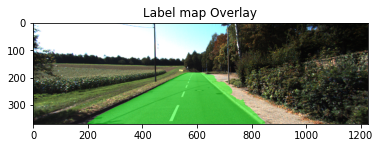

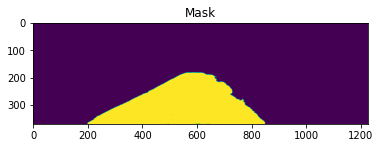

In [35]:
from matplotlib import pyplot as plt 


# show image using matplotlib

img = PIL.Image.open('./output/overlay_1000.png')
mask = PIL.Image.open('./output/mask_1000.png')
plt.imshow(img), plt.title('Label map Overlay');
plt.figure(), plt.imshow(mask), plt.title('Mask');

# Load trained model and test

In [34]:
# device = "cpu" # cuda  / cuda:0  / ...
device = "cuda" if torch.cuda.is_available() else "cpu"

net = UNet(2, 32)
    
net = net.to(device)
net = torch.nn.DataParallel(net)

net.load_state_dict(torch.load('trained_model.pkl'))

# validation
net.eval()

val_loss = 0

for batch_idx, (data, target) in enumerate(val_loader):
    # TODO
    # load data
    data, target = data.to(device), target.to(device)
    # forward
    score = net(data)

    loss = criterion(score, target)
    val_loss += loss.item() / len(data)

val_loss /= len(val_loader)
print ('val loss : %f'%val_loss)

#visualization
img = PIL.Image.open('./data/Kitti/data_road/testing/image_2/um_000081.png')
visualization(net, img, 999, device)

val loss : 0.167631


# Optional homework
## Improving the segmentation model

> 모델의 성능을 개선하는 방법은 다양합니다. 모델의 parameter 수를 늘리는 방법도 있고, optimizer를 변경하거나 learning rate, batch size를 변경하는 방법도 있습니다. 그리고 loss function을 변경하는 방법도 있습니다. 